In [1]:
import numpy as np
from scipy import linalg as la
from os import walk
from scipy.ndimage import imread
from matplotlib import pyplot as plt
from random import sample
%matplotlib inline

In [2]:
# Helper function to plot flattened images
def plot(img, w=200, h=180):
    plt.imshow(img.reshape((w,h)), cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [3]:
def sample_faces(n_tests, path = "faces94"):
    """Return an array containing a sample of n_tests images contained
    in the path as flattened images in the columns of the output.
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                files.append(dirpath+"/"+f)
    # Get a sample of the images
    test_files = sample(files, n_tests)
    # Flatten and average the pixel values
    images = np.array([plt.imread(f).mean(axis=2).ravel() for f in test_files]).T
    return images

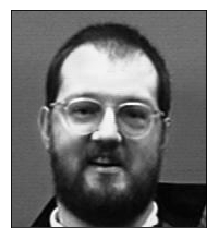

In [4]:
def get_faces(path="faces94"):
    """Traverse the directory specified by 'path' and return an array containing one column vector per subdirectory.
    For the faces94 dataset, this gives an array with just one column for each
    face in the dataset. Each column corresponds to a flattened grayscale image.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        i = 0
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                 # load image, convert to grayscale, flatten into vector
                face = plt.imread(dirpath+"/"+f).mean(axis=2).ravel()
                faces.append(face)
                i += 1
            if i == 3:
                break
    # put all the face vectors column-wise into a matrix.
    F = np.array(faces).T
    return F

faces = get_faces()
plot(faces[:,20])

In [7]:
class FacialRec:
    ########## Members ##########
    #   F, mu, Fbar, and U      #
    #############################
    def __init__(self,path="faces94"):
        self.init_faces(path)
        self.init_mean_image()
        self.init_differences()
        self.init_eigenfaces()
        self.Fhat = None
        
    def init_faces(self, path):
        self.images = get_faces(path)
        
    def init_mean_image(self):
        self.mu = self.images.mean(axis=1)
        
    def init_differences(self):
        self.Fbar = self.images - self.mu.reshape((len(self.mu),1))
        
    def init_eigenfaces(self):
        U, Sigma, Vh = la.svd(self.images, full_matrices=False)
        self.U = U
        
    def project(self, A, s=19):
        return self.U[:,:s].T.dot(A)
    
    def find_nearest(self, image, s=38, ep=.001):
        if not self.Fhat:
            Fhat = self.project(self.Fbar, s)
            self.Fhat = Fhat
        ghat = self.project(image-self.mu.reshape((len(self.mu),1)), s)
        return np.argmin(np.linalg.norm(self.Fhat-ghat, ord=2, axis=0))

### Plot the mean face.

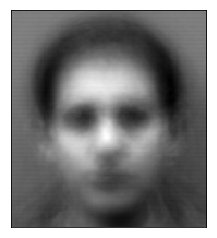

In [8]:
FR = FacialRec()
plot(FR.mu)

### Plot a mean-shifted face.

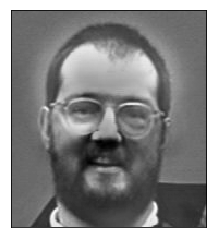

In [9]:
plot(FR.Fbar[:,20])

### Plot an eigenface.

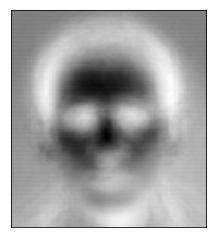

In [10]:
plot(FR.U[:,0])

### Project the first mean-shifted face in terms of the first 19 eigenvalues. Change back to the standard basis on $\mathbb{R}^{mn}$. Add the mean face.  Plot the result

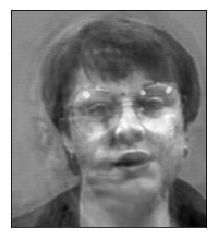

In [11]:
face = FR.project(FR.Fbar[:,0])
face = FR.U[:,:19].dot(face)
face += FR.mu
plot(face)

### Plot a random face beside the face returned by the FacialRec class.

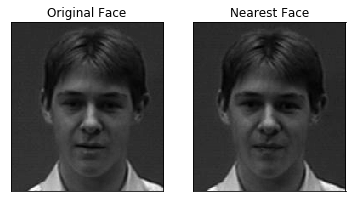

In [12]:
sample_face = sample_faces(1)
index = FR.find_nearest(sample_face, 16)
plt.subplot(121)
plt.title("Original Face")
plot(sample_face)
plt.subplot(122)
plt.title("Nearest Face")
plot(faces[:,index])